In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [3]:
N_SAMPLES = 4000
N_THRESHOLDS = 80
CLASS_1_RATIO = 0.08

y_true = np.array([
    int(random.random()<=CLASS_1_RATIO)
    for i in range(N_SAMPLES)
])
y_pred = np.array([
    # formula to fake a not so bad prediction
    random.triangular(0,1, 0.6 if y_true[i] else 0.2)
    for i in range(N_SAMPLES)
])

THRESHOLDS = [ i/float(N_THRESHOLDS) for i in range(N_THRESHOLDS+1) ]

In [4]:
def cm(y_true, y_pred, threshold =0.5):
    return confusion_matrix(
        y_true,
        y_pred>=threshold
    )
def confusion_curve(y_true, y_pred):
    return [
        cm(y_true, y_pred, thr).flatten()
        for thr in THRESHOLDS
    ]

print("Confusion matrix at 50%:\n", cm(y_true, y_pred))

Confusion matrix at 50%:
 [[2525 1152]
 [ 144  179]]


In [5]:
CURVES = pd.DataFrame(
    confusion_curve(y_true, y_pred),
    columns = [ 'TN', 'FP', 'FN', 'TP', ]
) / N_SAMPLES  # Normalized per sample

CURVES['threshold'] = THRESHOLDS

In [10]:
# W0 = volume of interests that are paid back
# W1 = estimation of the averaged capital lost for bad customers
# if W1/W0 penalty is lower than (1/class1ratio - 1) then gains are always positive
#    (8% => W1/W0 = 11.5)
# but it doesn't mean maximal gain at any threshold!!
################
W0 =   8000.0  # penalty=12.5
W1 = 100000.0  #
################

CURVES['EARNED']     = W0*CURVES.TN
CURVES['NOT_EARNED'] = W0*CURVES.FP
CURVES['LOST']       = W1*CURVES.FN
CURVES['NOT_LOST']   = W1*CURVES.TP
CURVES['GAIN']       = CURVES.EARNED - CURVES.LOST
CURVES['THEORY_GAIN']= CURVES.EARNED + CURVES.NOT_EARNED
CURVES['MAX_GAIN']   = W0
CURVES["CONSTANT_COST"]  = - W0*CURVES.TP[0]
CURVES["REJECTING_COST"] = - CURVES.NOT_EARNED
CURVES["ACCEPTING_COST"] = - CURVES.LOST
CURVES["MINUS_EARNED"]   = - CURVES.GAIN

COLORS = {}
def add_color(color, keys):
    for key in keys:
        COLORS[key] = color
        
add_color("green" , ["TN", "EARNED"    , "MINUS_EARNED"  , ])
add_color("blue"  , ["TP", "NOT_LOST"  , "MAX_GAIN"   , "CONSTANT_COST" , ])
add_color("red"   , ["FN", "LOST"      ,                "ACCEPTING_COST", ])
add_color("orange", ["FP", "NOT_EARNED", "THEORY_GAIN", "REJECTING_COST", ])
add_color("yellow", ["GAIN" ])


COMMON_GRAPH_OPTIONS = dict(
    x='threshold',
    color=COLORS,
)

In [11]:
COLORS

{'TN': 'green',
 'EARNED': 'green',
 'MINUS_EARNED': 'green',
 'TP': 'blue',
 'NOT_LOST': 'blue',
 'MAX_GAIN': 'blue',
 'CONSTANT_COST': 'blue',
 'FN': 'red',
 'LOST': 'red',
 'ACCEPTING_COST': 'red',
 'FP': 'orange',
 'NOT_EARNED': 'orange',
 'THEORY_GAIN': 'orange',
 'REJECTING_COST': 'orange',
 'GAIN': 'yellow'}

(-1472.0, 8832.0)

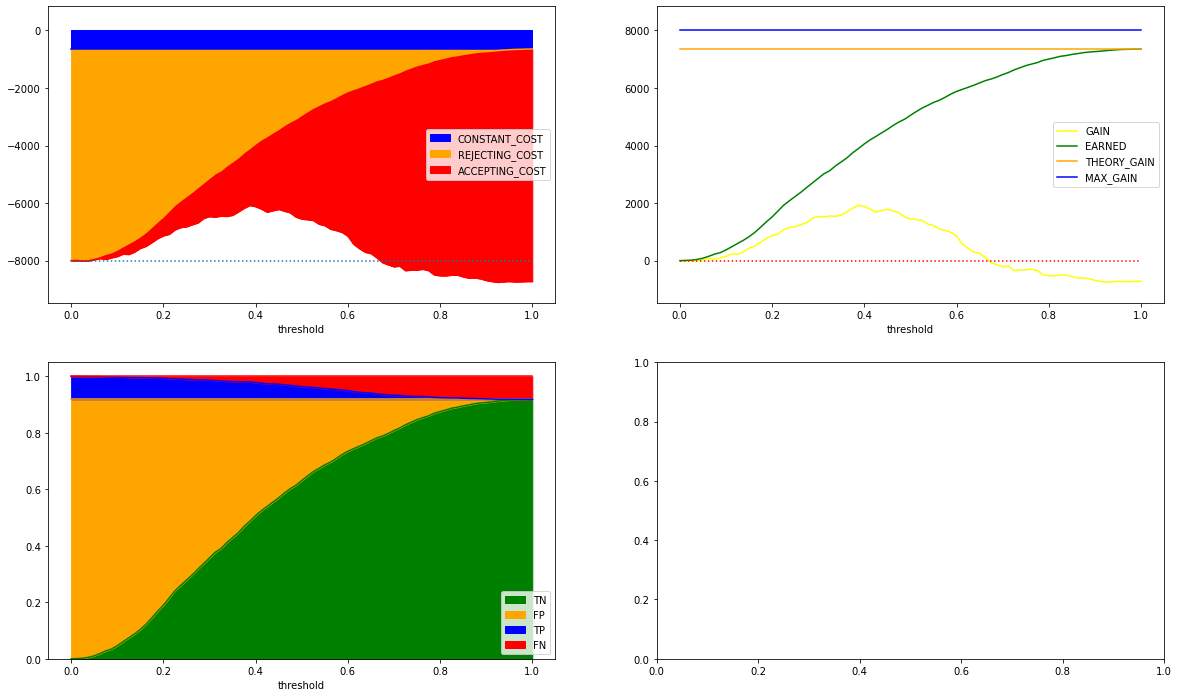

In [12]:
fig, ax = plt.subplots(2, 2, figsize =(20, 12))
CURVES.plot.area(
    ax=ax[1][0],
    y=['TN', 'FP', 'TP', 'FN', ],
    stacked=True,
    **COMMON_GRAPH_OPTIONS
)

# CURVES.plot(
#     ax=ax[1][1],
#     y=['EARNED', 'LOST'],
#     **COMMON_GRAPH_OPTIONS
# )
# ax[0][1].plot([0,1],[0,0], 'r:')

MAX_GAIN = W0
MAX_LOST = (W1+W0)*CLASS_1_RATIO
MARGIN = 0.05*(MAX_GAIN+MAX_LOST)

CURVES.plot.area(
    ax=ax[0][0],
    y=['CONSTANT_COST', 'REJECTING_COST', 'ACCEPTING_COST', ],
    stacked=True,
    **COMMON_GRAPH_OPTIONS
)
ax[0][0].plot([0, 1],[-W0, -W0], ':')
ax[0][0].set_ylim(
    - MARGIN - max(MAX_GAIN, MAX_LOST),
    + MARGIN,
)

CURVES.plot(
    ax=ax[0][1],
    y=['GAIN', 'EARNED', 'THEORY_GAIN', 'MAX_GAIN'],
    **COMMON_GRAPH_OPTIONS
)
ax[0][1].plot([0,1],[0,0], 'r:')
ax[0][1].set_ylim(
    - MARGIN + MAX_GAIN - max(MAX_GAIN, MAX_LOST),
    + MARGIN + MAX_GAIN,
)
